# Avito Deal Prediction: Stage 1v1 Model
This Stage 1v1 model explores the effect of introducing a binary classifier as the first model in a pipeline. The binary classifier will predict whether an ad posting has a success likelihood of over or under 0.6. (This threshold was determined during Stage 0 data exploration while I was examining the distribution of deal probability.)

After the data is bisected by the given threshold, Light GBM regressors will be trained and run to predict the deal probabilities on the "below threshold" and "above threshold" sets. 

In [1]:
import pandas as pd
import numpy as np
import os
import json
import pickle

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import mean_squared_error
from sklearn.metrics import log_loss
from sklearn.metrics import accuracy_score

from sklearn.utils import resample

import lightgbm as lgb

## Helper Functions:

In [2]:
def make_submission(test_predictions, item_id_list, csv_path):
    test_predictions = np.clip(test_predictions,0,1)
    rows = np.stack((item_id_list, test_predictions)).T
    df = pd.DataFrame(columns=['item_id', 'deal_probability'], data=rows)
    df.to_csv(csv_path, index=False)
    return None

In [3]:
def run_training(sname, params, num_boost, vnum, train, labels, test):
    print 'Start training on %s'%sname
    
    # Create train, val, test splits
    train_df, val_df, train_label_df, val_label_df = train_test_split(train, labels, test_size=0.2, random_state=0)
    # Format for LightGBM training
    d_train = lgb.Dataset(train_df, label=train_label_df)
    d_val = lgb.Dataset(val_df, label=val_label_df)
    
    # Train model
    evals_result = {}  # Record results for plotting
    lgbm = lgb.train(params, d_train, num_boost_round=num_boost, valid_sets=[d_val], evals_result=evals_result, 
                     verbose_eval=vnum)
    
    # Get predictions
    train_pred = lgbm.predict(train)
    test_pred=lgbm.predict(test)
    
    # Make plots
    ax = lgb.plot_metric(evals_result, metric=params['metric'], figsize=(12, 7), grid=False)
    plt.show()
    ax = lgb.plot_importance(lgbm, max_num_features=10, figsize=(12, 7), grid=False)
    plt.show()
    
    return train_pred, test_pred

## General Setup

In [4]:
# Load parameters file
with open('setup_param.json', 'r') as handle:
    setup_params = json.load(handle)

In [5]:
parent_path = setup_params['parent_dir']
data_path = setup_params['data_dir']
scripts_path = setup_params['scripts_dir']
train_csv_path = setup_params['train_csv']
test_csv_path = setup_params['test_csv']

# Light GBM parameters
model_path_1 = setup_params['model_dir_1']

# Training and test sets
labels_path = setup_params['train_labels']
train_data_path = setup_params['stage0_train']

test_data_path = setup_params['stage0_test']
test_items_path = setup_params['test_items']

In [6]:
# Submission path
submission_path = model_path_1 + 'binary_submission' + ".csv"

## Loading Training and Test Data:

In [7]:
features_list = ['population', 'area', 'latitude', 'longitude', 'density', 'pcn_0',\
                 'pcn_1', 'pcn_2', 'pcn_3', 'pcn_4', 'pcn_5', 'pcn_6', 'pcn_7',\
                 'pcn_8', 'title_count', 'desc_count', 'usetyp_0', 'usetyp_1',\
                 'usetyp_2', 'price', 'image_top_1']
label_name = 'deal_probability'

In [8]:
train_df = pd.read_csv(train_data_path)
test_df = pd.read_csv(test_data_path)

dropped_features = [x for x in train_df.columns.values if x not in features_list]
# Drop features (if any)
train_df.drop(labels=dropped_features, axis=1, inplace=True)
test_df.drop(labels=dropped_features, axis=1, inplace=True)

In [9]:
if label_name == 'deal_probability':
    label_csv = pd.read_csv(labels_path)
    label_csv = label_csv.deal_prob.values
else:
    label_csv = np.asarray(train[label_name])

In [10]:
# Standardize data
sc = StandardScaler()
train = sc.fit_transform(train_df)
test = sc.transform(test_df)
# Reformat into pandas dataframe
train = pd.DataFrame(data=train, columns=features_list)
test = pd.DataFrame(data=test, columns=features_list)

## Split Dataset by Deal Probability:

In [11]:
threshold = 0.6
bin_labels = np.zeros(len(label_csv))
bin_split_index = np.where(label_csv < threshold)[0]  # Below threshold (majority) == 1
bin_labels[bin_split_index] = 1

Start training on binary
[50]	valid_0's binary_logloss: 0.489591
[100]	valid_0's binary_logloss: 0.399243
[150]	valid_0's binary_logloss: 0.355624
[200]	valid_0's binary_logloss: 0.333692
[250]	valid_0's binary_logloss: 0.322371
[300]	valid_0's binary_logloss: 0.31623
[350]	valid_0's binary_logloss: 0.312572
[400]	valid_0's binary_logloss: 0.310082
[450]	valid_0's binary_logloss: 0.308377
[500]	valid_0's binary_logloss: 0.307237


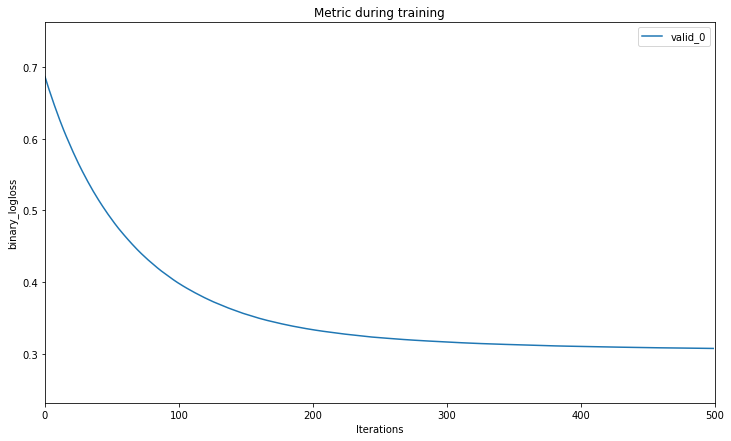

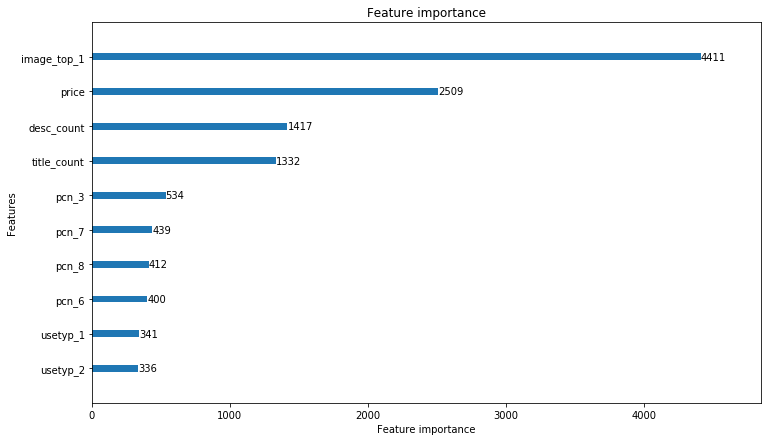

Training logloss: 0.3063613197151938
Training accuracy: 0.8851674577497766


In [12]:
params = {}
params['learning_rate'] = 0.01
params['boosting_type'] = 'gbdt'
params['objective'] = 'binary'
params['metric'] = 'binary_logloss'
params['num_leaves'] = 30
params['feature_fraction'] = .6
params['bagging_fraction'] = .8

n_boost = 500
v_num = n_boost/10

trainpred, testpred = run_training('binary', params, n_boost, v_num, train, bin_labels, test)

print 'Training logloss:', log_loss(y_pred=trainpred, y_true=bin_labels)
print 'Training accuracy:', accuracy_score(y_pred=np.rint(trainpred), y_true=bin_labels)

## Make Dataset Splits Based on Prediction:

In [13]:
# Find proper split point
print 'Range of predictions in train set:', np.amin(trainpred), np.amax(trainpred)
print 'Range of predictions in test set:', np.amin(testpred), np.amax(testpred)

Range of predictions in train set: 0.46317650486138445 0.98742320791334
Range of predictions in test set: 0.43763820014014065 0.9873999491140294


In [14]:
cutoff = [.55, 0.6, 0.7, .76, 0.8]
for val in cutoff:
    cls_train_pred = np.ones(len(trainpred))
    cls_test_pred = np.ones(len(testpred))
    
    cls_train_pred[np.where(trainpred < val)[0]] = 0
    cls_test_pred[np.where(testpred < val)[0]] = 0
    
    print 'Cutoff:', val
    print 'Number of above threshold values:', len(np.where(cls_train_pred == 0)[0])
    print 'Training accuracy:', accuracy_score(y_pred = cls_train_pred, y_true = bin_labels), '\n'

Cutoff: 0.55
Number of above threshold values: 4225
Training accuracy: 0.885487394108382 

Cutoff: 0.6
Number of above threshold values: 12057
Training accuracy: 0.8857162051423949 

Cutoff: 0.7
Number of above threshold values: 78083
Training accuracy: 0.8773326752798944 

Cutoff: 0.76
Number of above threshold values: 166521
Training accuracy: 0.8534046283683112 

Cutoff: 0.8
Number of above threshold values: 287144
Training accuracy: 0.8095906410965902 



In [15]:
print 'Number of above threshold values in training set:', len(bin_labels) - np.count_nonzero(bin_labels)

Number of above threshold values in training set: 172844


In [16]:
split_threshold = 0.55
cls_results_train = np.ones(len(trainpred))
cls_results_train[np.where(trainpred < split_threshold)[0]] = 0

cls_results_test = np.ones(len(testpred))
cls_results_test[np.where(testpred < split_threshold)[0]] = 0

In [17]:
below_train_idx = np.where(cls_results_train == 1)[0]
above_train_idx = np.where(cls_results_train == 0)[0]

below_test_idx = np.where(cls_results_test == 1)[0]
above_test_idx = np.where(cls_results_test == 0)[0]

In [18]:
above_train = train.iloc[above_train_idx]
above_label = label_csv[above_train_idx]
above_test = test.iloc[above_test_idx]

below_train = train.iloc[below_train_idx]
below_label = label_csv[below_train_idx]
below_test = test.iloc[below_test_idx]

## Regressors:

In [19]:
train_pred = np.zeros(train.shape[0])
test_pred = np.zeros(test.shape[0])

### Above Regressor:

Start training on stageabove
[20]	valid_0's rmse: 0.369068
[40]	valid_0's rmse: 0.367569
[60]	valid_0's rmse: 0.366422
[80]	valid_0's rmse: 0.365231
[100]	valid_0's rmse: 0.36436
[120]	valid_0's rmse: 0.363484
[140]	valid_0's rmse: 0.363246
[160]	valid_0's rmse: 0.362792
[180]	valid_0's rmse: 0.36241
[200]	valid_0's rmse: 0.362296


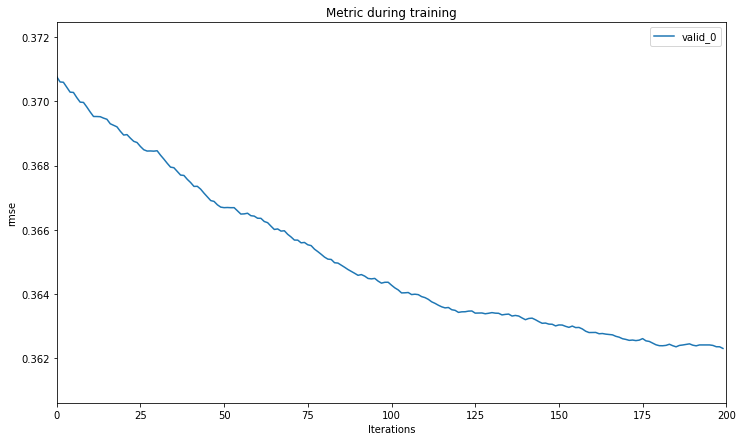

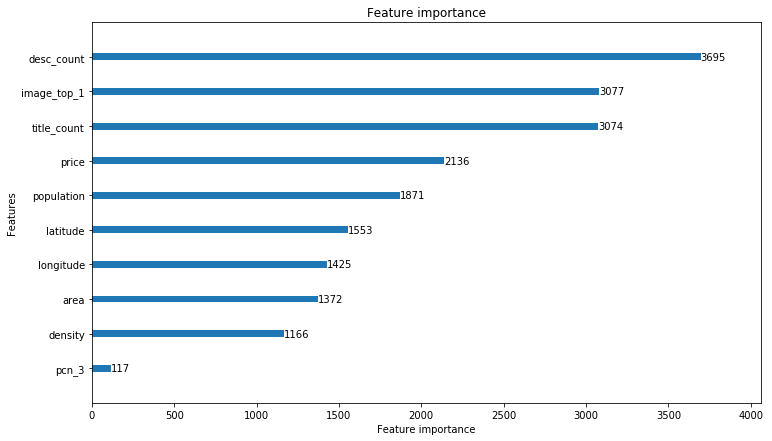

Training error: 0.3322126680831897


In [20]:
i = 'above'
stage_name = 'stage%s'%i

# Parameters
params = {}
params['learning_rate'] = 0.005
params['boosting_type'] = 'gbdt'
params['objective'] = 'regression'
params['metric'] = 'rmse'
params['num_leaves'] = 100
params['feature_fraction'] = .6
params['bagging_fraction'] = .8
n_boost = 200
v_num = n_boost/10

trainpred, testpred = run_training(stage_name, params, n_boost, v_num, above_train, above_label, above_test)
# Evalulate training error
print 'Training error:', np.sqrt(mean_squared_error(y_pred=trainpred, y_true=above_label))

# Append to training and test predictions
train_pred[above_train_idx] = trainpred
test_pred[above_test_idx] = testpred

### Below Regressor:

Start training on stagebelow
[50]	valid_0's rmse: 0.251754
[100]	valid_0's rmse: 0.246864
[150]	valid_0's rmse: 0.243342
[200]	valid_0's rmse: 0.2407
[250]	valid_0's rmse: 0.238831
[300]	valid_0's rmse: 0.237481
[350]	valid_0's rmse: 0.236452
[400]	valid_0's rmse: 0.235578
[450]	valid_0's rmse: 0.234866
[500]	valid_0's rmse: 0.234322


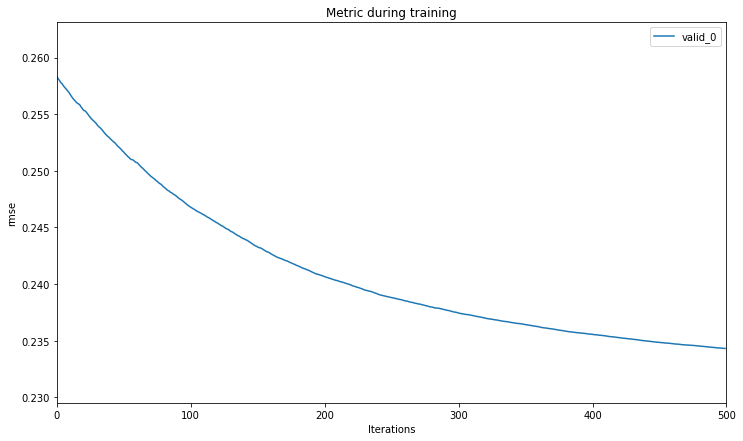

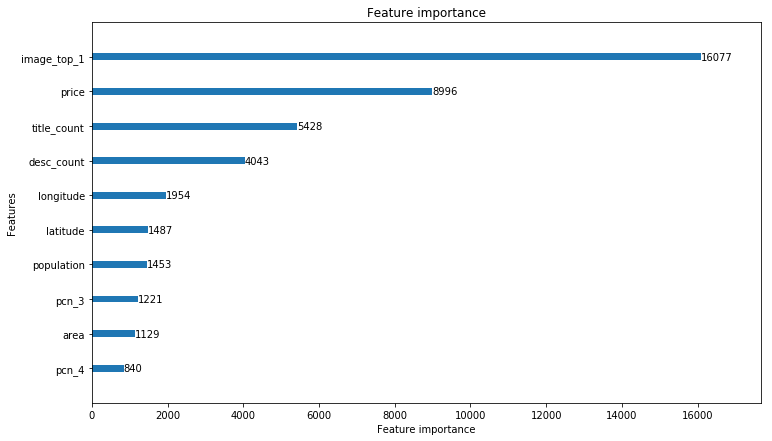

Training error: 0.23416364874923856


In [21]:
i = 'below'
stage_name = 'stage%s'%i

# Parameters
params = {}
params['learning_rate'] = 0.005
params['boosting_type'] = 'gbdt'
params['objective'] = 'regression'
params['metric'] = 'rmse'
params['num_leaves'] = 100
params['feature_fraction'] = .6
params['bagging_fraction'] = .8
n_boost = 500
v_num = n_boost/10

trainpred, testpred = run_training(stage_name, params, n_boost, v_num, below_train, below_label, below_test)
# Evalulate training error
print 'Training error:', np.sqrt(mean_squared_error(y_pred=trainpred, y_true=below_label))

# Append to training and test predictions
train_pred[below_train_idx] = trainpred
test_pred[below_test_idx] = testpred

### Evaluate Overall Training Error:

In [22]:
print 'Overall training error:', np.sqrt(mean_squared_error(y_pred=train_pred, y_true=label_csv))

Overall training error: 0.23449664198843231


### Explore Errors:

In [23]:
eval_df = pd.concat((train, pd.Series(label_csv, name='deal_prob'), pd.Series(train_pred, name='pred')), axis=1)
eval_df['error'] = np.around(np.square(np.subtract(eval_df.deal_prob, eval_df.pred)), decimals=4)

In [24]:
# Error statistics
eval_df.error.describe()

count    1.503424e+06
mean     5.498862e-02
std      1.167657e-01
min      0.000000e+00
25%      3.800000e-03
50%      8.900000e-03
75%      3.350000e-02
max      6.813000e-01
Name: error, dtype: float64

In [25]:
err_thresh = eval_df.error.mean() + eval_df.error.std()

above_eval = eval_df.loc[(eval_df.error >= err_thresh)]
below_eval = eval_df.loc[(eval_df.error < err_thresh)]

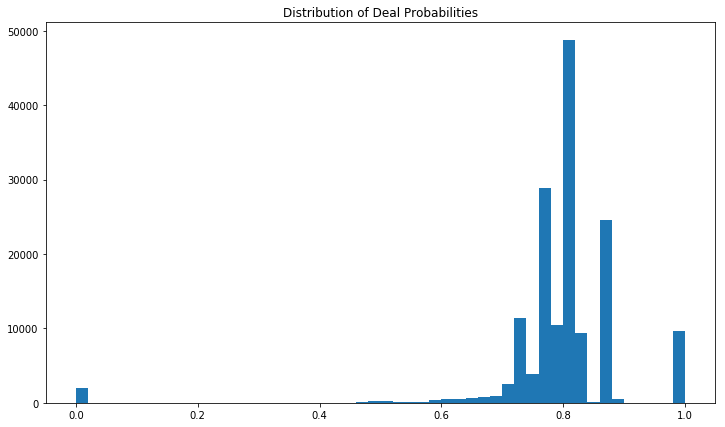

In [26]:
above_eval.deal_prob.hist(bins=50, figsize=(12, 7), grid=False)
# below_eval.deal_prob.hist(bins=50, figsize=(12, 7), grid=False)
plt.title('Distribution of Deal Probabilities')
plt.show()

## Make Submission:

In [27]:
# Make submission script
with open(test_items_path, 'rb') as handle:
    test_item_id = pickle.load(handle)
make_submission(test_pred, test_item_id, submission_path)